# Marco del problema

El objetivo es predecir el precio del airbnb utilizando los datos disponibles.

En este caso, estamos hablando de un problema supervisado, ya que los datos están etiquetados para el entrenamiento. Al ser un problema de predicción, estamos ante un caso de regresión, concretamente, de regresión múltiple, ya que tenemos varias características para predecir el valor. Como solamente tenemos que predecir un valor, estamos hablando de una regresión univariante.

Al tratarse de un problema de regresión, tomaremos como medida de confianza el error cuadrático medio **RMSE**

# Carga de datos

Cargamos los datos del dataset usando Pandas, creamos una función para ello

In [1]:
import pandas as pd
import os

# Carga el dataset y devuelve un dataframe de Pandas
def load_airbnb_dataset(ruta):
    csv_path = os.path.join(ruta, "airbnb-listings.csv")
    return pd.read_csv(csv_path, sep=';')

In [2]:
housing = load_airbnb_dataset('datasets')
housing.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,11210388,https://www.airbnb.com/rooms/11210388,20170306202425,2017-03-07,The Loft-Full Bath-Deck w/View,Loft in the Hill country 12-15 minutes directl...,This loft has a spectacular view of the hills ...,Loft in the Hill country 12-15 minutes directl...,none,This neighborhood is located in the hills west...,...,10.0,10.0,10.0,NaN,NaN,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,17471131,https://www.airbnb.com/rooms/17471131,20170407214050,2017-04-08,"Claris I, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,10.0,8.0,10.0,HUTB-006721,NaN,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ..."
2,17584891,https://www.airbnb.com/rooms/17584891,20170407214050,2017-04-08,"Style Terrace Red, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,NaN,NaN,NaN,HUTB-007527,NaN,super_strict_30,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ..."
3,5398030,https://www.airbnb.com/rooms/5398030,20170407214050,2017-04-08,Picasso Suite 1.4 Paseo de Gracia,Live like a local in Barcelona's most chic dis...,You wake up to the sun rising over Barcelona's...,Live like a local in Barcelona's most chic dis...,none,We're right in the heart of the chic L'Eixampl...,...,10.0,10.0,9.0,NaN,NaN,strict,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re..."
4,18104606,https://www.airbnb.com/rooms/18104606,20170407214050,2017-04-08,Smart City Centre Apartment II,"Unique apartment in vibrant neighborhoods, car...","License: HUTB-005313 Charming apartment, locat...","Unique apartment in vibrant neighborhoods, car...",none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is..."


Al usar la instrucción **head** de Pandas, obtenemos una primera visión de los datos. 

Cada fila corresponde a un apartamento, la primera fila contiene los nombres de las columnas.

# Estructura de los datos

Con la instrucción **înfo** vemos una pequeña descripción de los datos.

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 89 columns):
ID                                14780 non-null int64
Listing Url                       14780 non-null object
Scrape ID                         14780 non-null int64
Last Scraped                      14780 non-null object
Name                              14779 non-null object
Summary                           14189 non-null object
Space                             10888 non-null object
Description                       14774 non-null object
Experiences Offered               14780 non-null object
Neighborhood Overview             9134 non-null object
Notes                             5644 non-null object
Transit                           9066 non-null object
Access                            8318 non-null object
Interaction                       8228 non-null object
House Rules                       9619 non-null object
Thumbnail Url                     11960 non-null object
Med

Vemos que tenemos un total de 89 variables y 14780 observaciones (muy pocas para los estándares de Machine Learning).

Hay variables, por ejemplo **Has Availability** que solo tiene 12 valores no nulos.

La variable a predecir **price** (de ahora en adelante **y**) tiene 14763 valores no nulos, por lo que hay 17 pisos sin precio.

Hay muchas variables de tipo **object**, al leer desde un CSV, es posible que san variables de texto.

Cuando hicimos el head, pudimos ver que la variable "Cancellation Policy" tiene valores repetitivos, por lo que podría ser categórica. Vamos a comprobar si hay más variables categóricas.

In [4]:
# Mostrar el value counts de cada una de las variables para encontrar variables categóricas

for i in housing.columns:
    print(housing.loc[:,i].value_counts())

   41
Sydney                      36
Vienna                      31
Amsterdam                   26
Copenhagen                  15
Brussels                    14
Toronto                     14
Venice                      13
D.C.                        13
Other (International)       12
Chicago                     10
Melbourne                    9
Seattle                      9
Edinburgh                    9
San Francisco                8
New Orleans                  6
Geneva                       5
Montreal                     4
Denver                       4
Athens                       4
Austin                       4
San Diego                    4
Manchester                   4
Antwerp                      3
Hong Kong                    3
Boston                       2
Vancouver                    2
Malibu                       1
Nashville                    1
Toledo                       1
Santiago                     1
East Bay, CA                 1
Byron Bay                    1
De

Vemos que las siguientes variables son categóricas:

- Host Response Time
- Property Type
- Room Type
- Bed Type
- Cancellation Policy

In [5]:
print('Host Response Time:')
print(housing.loc[:,'Host Response Time'].value_counts())
print()
print('Property Type:')
print(housing.loc[:,'Property Type'].value_counts())
print()
print('Room Type:')
print(housing.loc[:,'Room Type'].value_counts())
print()
print('Bed Type:')
print(housing.loc[:,'Bed Type'].value_counts())
print()
print('Cancellation Policy:')
print(housing.loc[:,'Cancellation Policy'].value_counts())

Host Response Time:
within an hour        7905
within a few hours    2872
within a day          1802
a few days or more     302
Name: Host Response Time, dtype: int64

Property Type:
Apartment             11962
House                  1368
Condominium             363
Bed & Breakfast         353
Loft                    305
Other                   225
Dorm                     44
Guesthouse               42
Chalet                   26
Villa                    19
Townhouse                17
Hostel                   16
Serviced apartment       13
Boutique hotel            6
Boat                      4
Camper/RV                 4
Earth House               3
Guest suite               3
Casa particular           3
Bungalow                  2
Tent                      1
Timeshare                 1
Name: Property Type, dtype: int64

Room Type:
Entire home/apt    8976
Private room       5595
Shared room         209
Name: Room Type, dtype: int64

Bed Type:
Real Bed         14456
Pull-out Sofa      

Analizamos los valores numéricos:

In [6]:
housing.describe()

,ID,Scrape ID,Host ID,Host Response Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,...,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
count,1.478000e+04,1.478000e+04,1.478000e+04,12881.000000,14777.000000,14777.000000,14780.000000,14780.000000,14780.000000,14725.000000,...,14780.000000,11476.000000,11454.000000,11460.000000,11443.000000,11460.000000,11440.000000,11439.000000,14776.000000,11618.000000
mean,1.028089e+07,2.017037e+13,3.608080e+07,94.823461,12.513636,12.513636,40.497626,-3.858041,3.277808,1.281732,...,22.632273,91.697978,9.416012,9.328883,9.621778,9.647033,9.532168,9.218201,9.486871,1.870014
std,5.564829e+06,5.667971e+08,3.425360e+07,15.215988,34.090223,34.090223,4.641387,14.123146,2.097291,0.658517,...,38.290244,8.989101,0.921938,0.989933,0.802736,0.767116,0.774527,0.950578,23.626014,1.867550
min,1.862800e+04,2.016010e+13,1.745300e+04,0.000000,0.000000,0.000000,-37.851182,-123.131344,1.000000,0.000000,...,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.020000
25%,5.554732e+06,2.017041e+13,6.787360e+06,100.000000,1.000000,1.000000,40.409726,-3.707604,2.000000,1.000000,...,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.450000
50%,1.133492e+07,2.017041e+13,2.464875e+07,100.000000,2.000000,2.000000,40.419466,-3.700785,3.000000,1.000000,...,7.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.200000
75%,1.532631e+07,2.017041e+13,5.432919e+07,100.000000,6.000000,6.000000,40.430916,-3.684057,4.000000,1.000000,...,27.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.780000
max,1.910969e+07,2.017062e+13,1.247534e+08,100.000000,519.000000,519.000000,55.966912,153.371427,16.000000,8.000000,...,446.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,145.000000,17.210000


Mostramos un histograma por cada variable numérica para seguir familiarizándonos con los datos

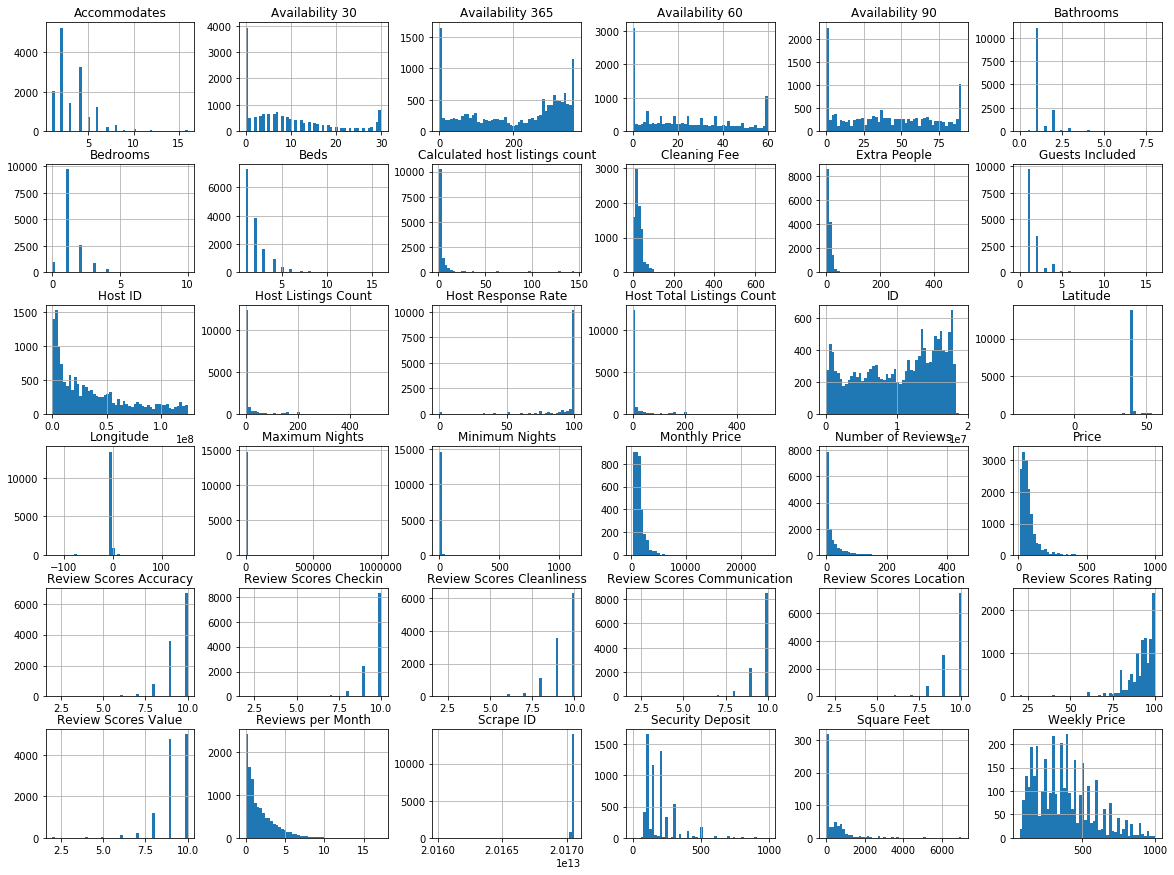

In [7]:
# Histograma
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## ¿Distribución del precio?

Si nos fijamos en el histograma de nuestra variable objetivo, parece que no siga una distribución normal, vamos a comprobarlo:

In [9]:
media = housing["Price"].mean()
mediana = housing["Price"].median()
moda = housing["Price"].mode()
desviacion = housing["Price"].std()

print("""
    Media: %d
    Mediana: %d
    Moda: %d
    Desviación: %d
""" % (media,mediana,moda, desviacion))


    Media: 73
    Mediana: 55
    Moda: 50
    Desviación: 72



Tal y como apuntaba el histograma, al ser la mediana, media y moda distintas y al ser 72 la desviación típica, el precio no sigue una distribución normal.

### Kolmogorov-Smirnov
Por si quedan dudas, hacemos el test de Kolmogorov-Smirnov

In [10]:
from scipy import stats

stats.kstest(housing["Price"].values, 'norm', args=(media, desviacion))

D:\Programas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
D:\Programas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
D:\Programas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
D:\Programas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


KstestResult(statistic=nan, pvalue=nan)

El test devuelve nulos, parece que en la variable precio hay algunos variables nulos, comprobamos que así es:

In [11]:
import math
for i in housing['Price']:
    if math.isnan(i):
        print(i)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


Generamos un nuevo dataframe sin nulos para poder hacer el test:

In [12]:
housingNoNulos = housing[housing['Price'].notnull()]

from scipy import stats

stats.kstest(housingNoNulos["Price"].values, 'norm', args=(media, desviacion))

KstestResult(statistic=0.19533838597584718, pvalue=0.0)

El p valor es 0, por lo tanto, no sigue una distribución normal

### Shapiro
Hago la prueba también con el test de Shapiro

In [13]:
df5kvalores = housingNoNulos[:5000]
stats.shapiro(df5kvalores["Price"].values)

(0.6307185292243958, 0.0)

El pvalor sigue siendo 0

# Dividir dataset en test & train
Para evitar obtener datos nunca vistos, dividimos el dataframe en dos partes, una para entrenamiento, y otra para pruebas. Evitamos mirar en el conjunto de test para no tropezarnos con algún patrón en los datos y enfocar nuestro modelo erróneamente.

In [14]:
housingNoNulos.describe()

,ID,Scrape ID,Host ID,Host Response Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,...,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
count,1.476300e+04,1.476300e+04,1.476300e+04,12867.000000,14760.000000,14760.000000,14763.000000,14763.000000,14763.000000,14709.000000,...,14763.000000,11467.000000,11445.000000,11451.000000,11434.000000,11451.00000,11431.000000,11430.000000,14759.000000,11609.000000
mean,1.028369e+07,2.017037e+13,3.609147e+07,94.845885,12.523645,12.523645,40.498426,-3.873973,3.274334,1.280407,...,22.647836,91.695474,9.415727,9.328705,9.621917,9.64728,9.532062,9.217935,9.493936,1.870469
std,5.564015e+06,5.671082e+08,3.425524e+07,15.161008,34.108196,34.108196,4.591761,14.075194,2.092835,0.654746,...,38.305035,8.990016,0.922171,0.990203,0.802589,0.76657,0.774597,0.950803,23.638296,1.867652
min,1.862800e+04,2.016010e+13,1.745300e+04,0.000000,0.000000,0.000000,-37.851182,-123.131344,1.000000,0.000000,...,0.000000,20.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,1.000000,0.020000
25%,5.558738e+06,2.017041e+13,6.800451e+06,100.000000,1.000000,1.000000,40.409728,-3.707608,2.000000,1.000000,...,1.000000,89.000000,9.000000,9.000000,9.000000,9.00000,9.000000,9.000000,1.000000,0.450000
50%,1.134222e+07,2.017041e+13,2.466866e+07,100.000000,2.000000,2.000000,40.419465,-3.700791,3.000000,1.000000,...,7.000000,94.000000,10.000000,10.000000,10.000000,10.00000,10.000000,9.000000,2.000000,1.200000
75%,1.532665e+07,2.017041e+13,5.434329e+07,100.000000,6.000000,6.000000,40.430902,-3.684171,4.000000,1.000000,...,27.000000,98.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,5.000000,2.780000
max,1.910969e+07,2.017062e+13,1.247534e+08,100.000000,519.000000,519.000000,55.966912,153.371427,16.000000,8.000000,...,446.000000,100.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,145.000000,17.210000
